In [2]:
#Importing packages we need
import numpy as np
import matplotlib.pyplot as plt #pyplot is used to plot the data
import scipy.optimize as opt #used to numerically optimize
from datetime import time, timedelta, datetime
import pandas as pd

In [3]:
def GaussianDensity(y,m,s):
    return np.exp(-0.5*np.log(np.pi)-0.5*np.log(s)-0.5*((y-m)**2)/s)

In [4]:
#getting data
#Locate my folder
#folder='e/august/code/jupyter/Markov/Finance A examples/' #remember it is written with "/" seperators like 'C:/Users/...' 
data=np.genfromtxt('SP500.csv', delimiter=',',usecols=np.arange(0,4)) #loading in first 4 columns
y = data[15097:, 3:4]*100 # 100 times log-returns of the S&P 500 index. January 4, 2010 - till end
y=y.T[0,:] #unpacking numpy array
T = len(y) #length of time series

In [56]:
def create_parameters(n_states, sigma2):
    # Create the transition matrix
    transition_matrix = np.full((n_states, n_states), (1 - 0.95) / (n_states - 1))
    np.fill_diagonal(transition_matrix, 0.95)
    transition_matrix = transition_matrix[:-1]  # Remove the last row

    # Generate sigma values
    sigmas = [np.sqrt(sigma2 * (2 ** (-i))) for i in range(n_states)]

    # Combine transition matrix and sigmas into one array
    parameters = np.concatenate((transition_matrix.flatten(), sigmas))
    #print(f'Sigmas given by {sigmas}')
    return np.array(parameters)

def parameter_bounds(n_states):
    # Transition probabilities bounds
    trans_bounds = [(0.001, 0.9999)] * n_states * (n_states - 1)

    # Sigma bounds
    sigma_bounds = [(0.01, 1000)] * n_states

    # Combine and return
    return trans_bounds + sigma_bounds

In [63]:
def likelihood(gamma, n_states=n_states):
    # Calculate the length of the transition matrix parameters
    transition_params_length = n_states * (n_states - 1)
    # print(y)
    # Check if params array has the correct length
    expected_length = transition_params_length + n_states
    # if gamma != expected_length:
    #     raise ValueError(f"Expected params of length {expected_length}, got {len(gamma)}")

    # Extract transition matrix parameters and sigma values
    transition_params = gamma[:transition_params_length].reshape((n_states - 1, n_states))
    sigma2 = gamma[transition_params_length:]**2
    T = len(y)  # Number of observations

    # Create transition matrix P
    P = np.zeros((n_states, n_states))
    P[:-1, :] = transition_params
    for i in range(n_states):
        P[-1, i] = 1 - sum(transition_params[:, i])
    print(P)
    
    #//bookkeeping
    xi_10      = np.zeros([n_states,T+1])
    xi_11      = np.zeros([n_states,T])
    xi_1T      = np.zeros([n_states,T])
    lik        = np.zeros(T)

    #//regression:
    A  = np.vstack(((np.identity(n_states)-P),np.ones([1,n_states])))
    pi_first = np.linalg.inv(A.T.dot(A)).dot(A.T)
    pi_second=np.vstack((np.zeros([n_states,1]),np.ones([1,1])))
    pi=pi_first.dot(pi_second)
    
    #print(f'The fist pi value is: {pi_first}')
    #print(f'The secon pi value is: {pi_second}')
    print(f'The full pi value is: {pi}')
    xi_10[:,0] = pi.T
    #//forward filter recursion
    eta=np.zeros(n_states)
    num=np.zeros(n_states)
    for t in range(T):
        #//state densities
        for state in range(n_states):
            eta[0]=GaussianDensity(y[t],0,sigma2[state])

        
        #likelihood
        #print(np.log(xi_10[[0,1],t]))
        lik[t]   = np.log(sum(xi_10[state,t]*eta[state] for state in range(n_states)))
        
        #filtering
        for state in range(n_states):
            numerator = eta[state] * xi_10[state, t]
            denominator = sum(eta[s] * xi_10[s, t] for s in range(n_states))
            xi_11[state, t] = numerator / denominator

        #prediction
        xi_10[:,t+1] = P.dot(xi_11[:,t])
    return -np.sum(lik) #We wish to minimize the likelihood in our scipy opt function

In [65]:
sigma2 = np.var(y) #used for initial guesses for sigma2 vals
n_states = 3
Gamma0  = create_parameters(n_states, sigma2)
my_bounds = parameter_bounds(n_states)
print(my_bounds)
res=opt.minimize(likelihood, Gamma0, method='L-BFGS-B',bounds=my_bounds) #optimizing. We use L-BFGS-B as it allows for bounds and can compute the standard errors (from the inverse hessian) right away
res.x
v_hessian=res.hess_inv.todense() #retrieves the negative inverse hessian matrix (note we have minimized the negative log likelihood function)
se_hessian=np.sqrt(np.diagonal(v_hessian))

[(0.001, 0.9999), (0.001, 0.9999), (0.001, 0.9999), (0.001, 0.9999), (0.001, 0.9999), (0.001, 0.9999), (0.01, 1000), (0.01, 1000), (0.01, 1000)]
[[0.95  0.025 0.025]
 [0.025 0.95  0.025]
 [0.025 0.025 0.95 ]]
The full pi value is: [[0.33333333]
 [0.33333333]
 [0.33333333]]
[[0.95000001 0.025      0.025     ]
 [0.025      0.95       0.025     ]
 [0.02499999 0.025      0.95      ]]
The full pi value is: [[0.33333338]
 [0.33333333]
 [0.33333329]]
[[0.95       0.02500001 0.025     ]
 [0.025      0.95       0.025     ]
 [0.025      0.02499999 0.95      ]]
The full pi value is: [[0.33333338]
 [0.33333333]
 [0.33333329]]
[[0.95       0.025      0.02500001]
 [0.025      0.95       0.025     ]
 [0.025      0.025      0.94999999]]
The full pi value is: [[0.33333338]
 [0.33333333]
 [0.33333329]]
[[0.95       0.025      0.025     ]
 [0.02500001 0.95       0.025     ]
 [0.02499999 0.025      0.95      ]]
The full pi value is: [[0.33333333]
 [0.33333338]
 [0.33333329]]
[[0.95       0.025      0.025 

/tmp/ipykernel_217799/1202227211.py:49: RuntimeWarning: invalid value encountered in log
  lik[t]   = np.log(sum(xi_10[state,t]*eta[state] for state in range(n_states)))


The full pi value is: [[-0.02399236]
 [-0.01270736]
 [ 1.03669972]]
[[ 0.9999      0.08177146  0.001     ]
 [ 0.06270373  0.96319374  0.001     ]
 [-0.06260373 -0.0449652   0.998     ]]
The full pi value is: [[-0.02399235]
 [-0.01270736]
 [ 1.03669971]]
[[ 0.9999      0.08177145  0.00100001]
 [ 0.06270373  0.96319374  0.001     ]
 [-0.06260373 -0.04496519  0.99799999]]
The full pi value is: [[-0.02399243]
 [-0.01270749]
 [ 1.03669992]]
[[ 0.9999      0.08177145  0.001     ]
 [ 0.06270374  0.96319374  0.001     ]
 [-0.06260374 -0.04496519  0.998     ]]
The full pi value is: [[-0.02399235]
 [-0.01270736]
 [ 1.03669971]]
[[ 0.9999      0.08177145  0.001     ]
 [ 0.06270373  0.96319375  0.001     ]
 [-0.06260373 -0.0449652   0.998     ]]
The full pi value is: [[-0.02399235]
 [-0.01270736]
 [ 1.03669971]]
[[ 0.9999      0.08177145  0.001     ]
 [ 0.06270373  0.96319374  0.00100001]
 [-0.06260373 -0.04496519  0.99799999]]
The full pi value is: [[-0.02399252]
 [-0.01270736]
 [ 1.03669988]]
[[

/tmp/ipykernel_217799/1202227211.py:49: RuntimeWarning: divide by zero encountered in log
  lik[t]   = np.log(sum(xi_10[state,t]*eta[state] for state in range(n_states)))
/tmp/ipykernel_217799/1202227211.py:55: RuntimeWarning: invalid value encountered in scalar divide
  xi_11[state, t] = numerator / denominator


[[ 0.9999      0.9999      0.00100001]
 [ 0.9999      0.9999      0.001     ]
 [-0.9998     -0.9998      0.99799999]]
The full pi value is: [[-0.0010022 ]
 [-0.00100221]
 [ 1.00200442]]
[[ 0.9999      0.9999      0.001     ]
 [ 0.99989999  0.9999      0.001     ]
 [-0.99979999 -0.9998      0.998     ]]
The full pi value is: [[-0.0010022 ]
 [-0.0010022 ]
 [ 1.00200441]]
[[ 0.9999      0.9999      0.001     ]
 [ 0.9999      0.99989999  0.001     ]
 [-0.9998     -0.99979999  0.998     ]]
The full pi value is: [[-0.0010022 ]
 [-0.0010022 ]
 [ 1.00200441]]
[[ 0.9999      0.9999      0.001     ]
 [ 0.9999      0.9999      0.00100001]
 [-0.9998     -0.9998      0.99799999]]
The full pi value is: [[-0.00100221]
 [-0.0010022 ]
 [ 1.00200442]]
[[ 0.9999  0.9999  0.001 ]
 [ 0.9999  0.9999  0.001 ]
 [-0.9998 -0.9998  0.998 ]]
The full pi value is: [[-0.0010022 ]
 [-0.0010022 ]
 [ 1.00200441]]
[[ 0.9999  0.9999  0.001 ]
 [ 0.9999  0.9999  0.001 ]
 [-0.9998 -0.9998  0.998 ]]
The full pi value is: [[

In [62]:
#result of optimization
Gamma_hat=res.x
se=se_hessian
print(P)
# Loop through each state
for state in range(n_states):
    # Printing Pii for each state (assuming Gamma_hat contains these values in order)
    print(f'P{state+1}{state+1}=' + str(Gamma_hat[state]) + ', std.errors=' + str(se[state]))

    # Printing hi for each state (assuming Gamma_hat and se have these values after Pii values)
    # Adjust the index appropriately if the structure of Gamma_hat and se is different
    if state + n_states < len(Gamma_hat):
        print(f'h{state+1}=' + str(Gamma_hat[state + n_states]) + ', std.errors=' + str(se[state + n_states]))


[[0.95  0.975]
 [0.05  0.025]]
P11=0.9999, std.errors=1.0
h1=0.03586737597093138, std.errors=1.0
P22=0.05837203776383935, std.errors=1.0
h2=0.9536648704366818, std.errors=1.0
P33=0.021947534362845154, std.errors=1.0
h3=0.0193133354907693, std.errors=1.0


In [47]:
#Plotting returns and filtered probabilities
gamma=Gamma_hat
#parameters
p00    = gamma[0]
p11    = gamma[1]
sigma2 = gamma[2:4]**2;
T      = len(y)
#//transition matrix
P = np.zeros([2,2])
P[0]=p00, 1-p11
P[1]=1-p00, p11
    
#//bookkeeping
xi_10      = np.zeros([2,T+1])
xi_11      = np.zeros([2,T])
xi_1T      = np.zeros([2,T])
lik        = np.zeros(T)

#//regression:
A  = np.vstack(((np.identity(2)-P),np.ones([1,2])))
pi_first = np.linalg.inv(A.T.dot(A)).dot(A.T)
pi_second=np.vstack((np.zeros([2,1]),np.ones([1,1])))
pi=pi_first.dot(pi_second)
xi_10[[0,1],0] = pi.T
#//forward filter recursion
eta=np.zeros(2)
for t in range(T):
    #//state densities
    eta[0]=GaussianDensity(y[t],0,sigma2[0])
    eta[1]=GaussianDensity(y[t],0,sigma2[1])
        
    #likelihood
    #print(np.log(xi_10[[0,1],t]))
    lik[t]   = np.log(xi_10[0,t]*eta[0]+xi_10[1,t]*eta[1])
        
    #filtering
    num0=eta[0]*xi_10[0,t]/(eta[0]*xi_10[0,t]+eta[1]*xi_10[1,t])
    num1=eta[1]*xi_10[1,t]/(eta[0]*xi_10[0,t]+eta[1]*xi_10[1,t])
    xi_11[[0,1],t] = num0,num1

    #prediction
    xi_10[[0,1],t+1] = P.dot(xi_11[[0,1],t])
    
    #Backward smoother (not needed for likelihood)
    xi_1T[:,T-1]=xi_11[:,T-1]
    for t in range(T-2,0,-1):
        xi_1T[:,t]=xi_11[:,t]*(P.T.dot(xi_1T[:,t+1]/xi_10[:,t+1]))
        
vol=np.zeros(len(y))
for i in range(T):
    vol[i]=xi_11[[0],i]*sigma2[0]+ (1-xi_11[[0],i])*sigma2[1]

/tmp/ipykernel_217799/2850974356.py:34: RuntimeWarning: divide by zero encountered in log
  lik[t]   = np.log(xi_10[0,t]*eta[0]+xi_10[1,t]*eta[1])
/tmp/ipykernel_217799/2850974356.py:37: RuntimeWarning: invalid value encountered in scalar divide
  num0=eta[0]*xi_10[0,t]/(eta[0]*xi_10[0,t]+eta[1]*xi_10[1,t])
/tmp/ipykernel_217799/2850974356.py:38: RuntimeWarning: invalid value encountered in scalar divide
  num1=eta[1]*xi_10[1,t]/(eta[0]*xi_10[0,t]+eta[1]*xi_10[1,t])
/tmp/ipykernel_217799/2850974356.py:47: RuntimeWarning: invalid value encountered in divide
  xi_1T[:,t]=xi_11[:,t]*(P.T.dot(xi_1T[:,t+1]/xi_10[:,t+1]))
/tmp/ipykernel_217799/2850974356.py:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  vol[i]=xi_11[[0],i]*sigma2[0]+ (1-xi_11[[0],i])*sigma2[1]


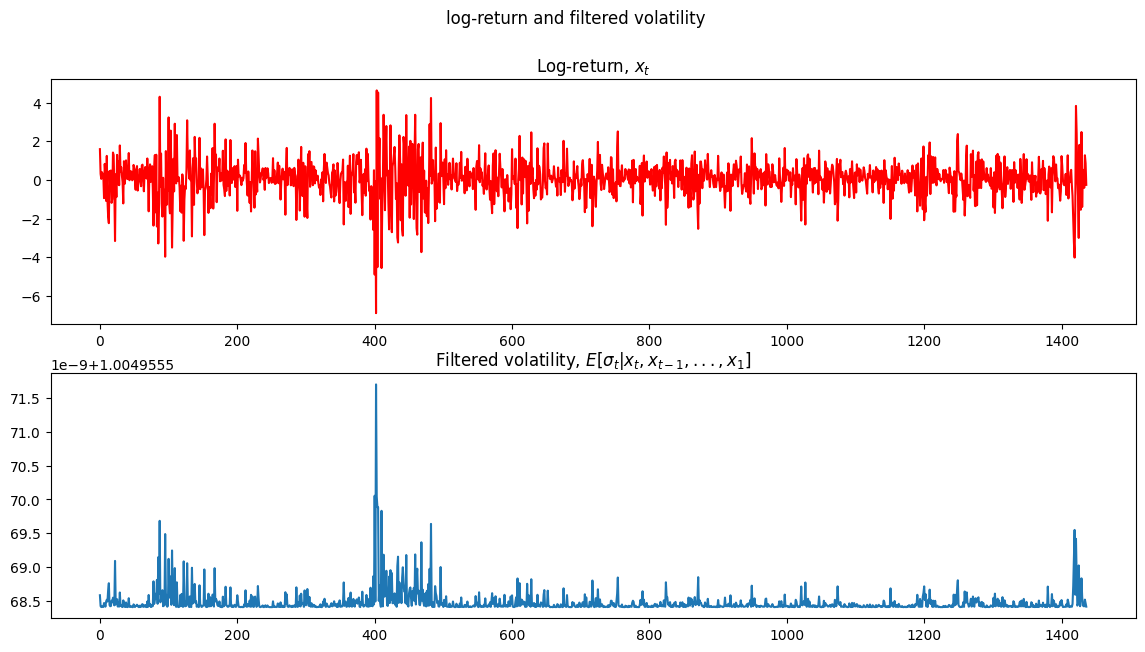

In [36]:
fig, ax=plt.subplots(2, figsize=(14,7))
#fig.set_figheight=(9)
#fig.set_figwidth=(16)
fig.suptitle('log-return and filtered volatility')
ax[0].plot(y,color='r')
ax[1].plot(np.sqrt(vol))

#Setting titles
ax[0].title.set_text('Log-return, $x_t$')
ax[1].title.set_text('Filtered volatility, $E[\sigma_t|x_t,x_{t-1},...,x_1]$')


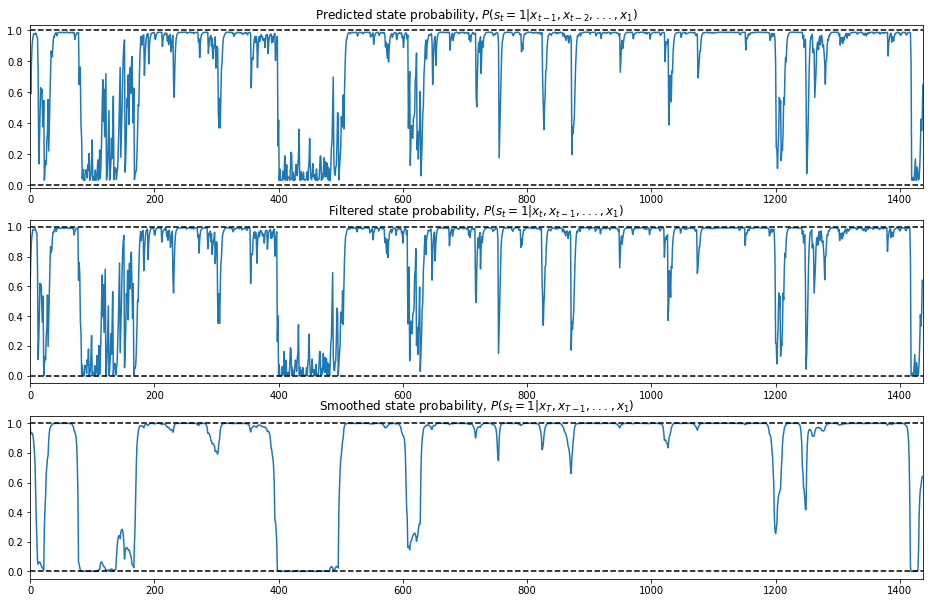

In [9]:
#Predicted state probability, Filtered state probability and smoothed state probability
fig, ax=plt.subplots(3, figsize=(16,9))
#fig.tight_layout() 

#Adjusting size between subplots
fig.subplots_adjust(left=None, bottom=0.025, right=None, top=None, wspace=None, hspace=None)
#default
#left  = 0.125  # the left side of the subplots of the figure
#right = 0.9    # the right side of the subplots of the figure
#bottom = 0.1   # the bottom of the subplots of the figure
#top = 0.9      # the top of the subplots of the figure
#wspace = 0.2   # the amount of width reserved for blank space between subplots
#hspace = 0.2   # the amount of height reserved for white space between subplots


ax[0].plot(1-xi_10[0,:])
ax[1].plot(1-xi_11[0,:])
ax[2].plot(1-xi_1T[0,:])

#Setting limits on x axis
ax[0].set_xlim(0, T)
ax[1].set_xlim(0, T)
ax[2].set_xlim(0, T)

#Setting titles
ax[0].title.set_text('Predicted state probability, $P(s_t=1|x_{t-1},x_{t-2},...,x_{1})$')
ax[1].title.set_text('Filtered state probability, $P(s_t=1|x_{t},x_{t-1},...,x_{1})$')
ax[2].title.set_text('Smoothed state probability, $P(s_t=1|x_{T},x_{T-1},...,x_{1})$')

#Setting lines at 0 and 1
ax[0].axhline(0,color='black', linestyle="--")
ax[0].axhline(1,color='black', linestyle="--")

ax[1].axhline(0,color='black', linestyle="--")
ax[1].axhline(1,color='black', linestyle="--")

ax[2].axhline(0,color='black', linestyle="--")
ax[2].axhline(1,color='black', linestyle="--")
